## 图像预处理

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from uuid import uuid4

In [4]:


def preprocess_region(image, region, operations=None):
    """
    从图像中提取特定区域并进行预处理
    
    参数:
    image: 原始图像 (numpy array)
    region: 要提取的区域，格式为 (x, y, width, height)
    operations: 预处理操作列表，可以包含 'grayscale', 'binary', 'denoise', 'sharpen'
    
    返回:
    处理后的图像区域
    """
    # 提取指定区域
    x, y, w, h = region
    roi = image[y:y+h, x:x+w]
    
    if operations is None:
        return roi
    
    for op in operations:
        if op == 'grayscale':
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        elif op == 'binary':
            if len(roi.shape) == 3:
                roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            _, roi = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        elif op == 'denoise':
            roi = cv2.fastNlMeansDenoising(roi)
        elif op == 'sharpen':
            kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
            roi = cv2.filter2D(roi, -1, kernel)
        elif op == 'super_resolution':
            roi = cv2.resize(roi, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    
    return roi

# 使用示例
image = cv2.imread('3.png')

# 定义要提取的区域 (x, y, width, height)
region = (0, 0, 3000, 5000)

# 定义预处理操作
operations = ['grayscale', 'binary', 'denoise', 'sharpen', "super_resolution"]

# 处理图像
processed_roi = preprocess_region(image, region, operations)

# 显示结果
# cv2.imshow('Processed Region', processed_roi)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# 保存结果
cv2.imwrite('1_2.jpg', processed_roi)

True

定义了一个 preprocess_region 函数，它可以：

从原始图像中提取指定区域
对提取的区域进行一系列预处理操作


预处理操作包括：

转换为灰度图 ('grayscale')
二值化 ('binary')
去噪 ('denoise')
锐化 ('sharpen')

## 行检测和分割


In [5]:
def detect_and_segment_lines(processed_image, min_line_height=5, min_line_gap=5):
    # 确保图像是二值化的
    if len(processed_image.shape) == 3:
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(processed_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # 计算水平投影
    h_proj = np.sum(binary, axis=1)
    
    # 找到行的起始和结束位置
    h, w = binary.shape
    line_positions = []
    start = None
    
    for i in range(h):
        if h_proj[i] > 0 and start is None:
            start = i
        elif h_proj[i] == 0 and start is not None:
            if i - start >= min_line_height:
                line_positions.append((start, i))
            start = None
        elif i == h - 1 and start is not None:
            line_positions.append((start, i))
    
    # 合并太近的行
    merged_line_positions = []
    for i, (start, end) in enumerate(line_positions):
        if i == 0 or start - merged_line_positions[-1][1] >= min_line_gap:
            merged_line_positions.append((start, end))
        else:
            merged_line_positions[-1] = (merged_line_positions[-1][0], end)
    
    # 分割行
    line_images = []
    for start, end in merged_line_positions:
        line_image = processed_image[start:end, :]
        line_images.append(line_image)
    
    return line_images, merged_line_positions

def visualize_lines(image, line_positions):
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

检测到 1 行


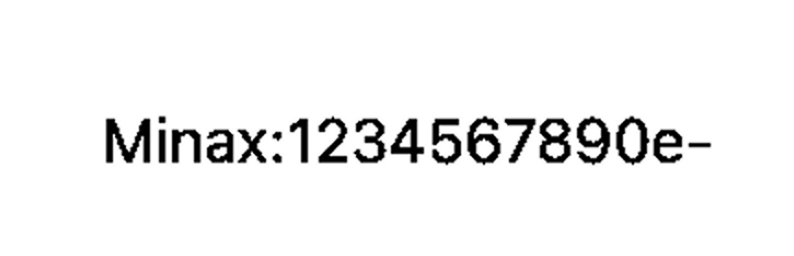

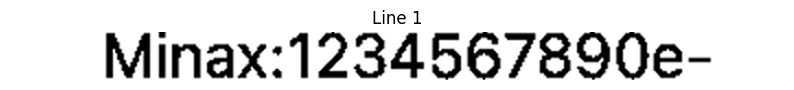

In [6]:

# 检测和分割行
line_images, line_positions = detect_and_segment_lines(processed_roi)

print(f"检测到 {len(line_images)} 行")

# 可视化检测结果
visualize_lines(processed_roi, line_positions)

# 显示分割后的每一行
for i, line_image in enumerate(line_images):
    plt.figure(figsize=(10, 2))
    plt.imshow(line_image, cmap='gray')
    plt.title(f"Line {i+1}")
    plt.axis('off')
    plt.show()


## 字符分割


### 垂直投影

行 1 检测到 18 个字符


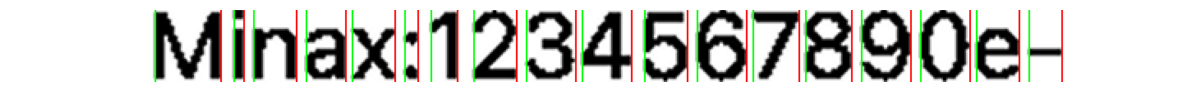

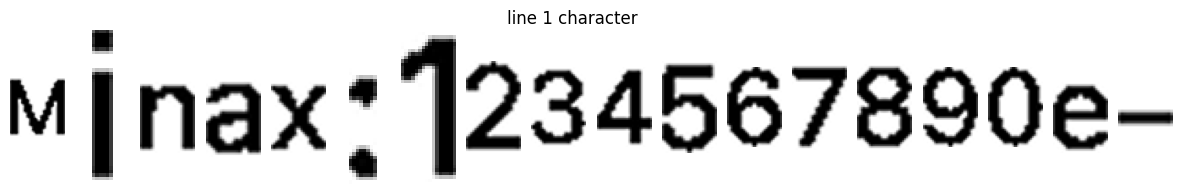

In [8]:
def segment_characters(line_image, min_char_width=2, min_char_gap=1):
    # 确保图像是二值化的
    if len(line_image.shape) == 3:
        line_image = cv2.cvtColor(line_image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(line_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # 计算垂直投影
    v_proj = np.sum(binary, axis=0)
    # print(v_proj)
    
    # 找到字符的起始和结束位置
    h, w = binary.shape
    char_positions = []
    start = None
    
    for i in range(w):
        if v_proj[i] > 0 and start is None:
            start = i
        elif v_proj[i] == 0 and start is not None:
            if i - start >= min_char_width:
                char_positions.append((start, i))
            start = None
        elif i == w - 1 and start is not None:
            char_positions.append((start, i))
    
    # 合并太近的字符
    merged_char_positions = []
    for i, (start, end) in enumerate(char_positions):
        if i == 0 or start - merged_char_positions[-1][1] >= min_char_gap:
            merged_char_positions.append((start, end))
        else:
            merged_char_positions[-1] = (merged_char_positions[-1][0], end)
    
    # 分割字符
    char_images = []
    for start, end in merged_char_positions:
        char_image = line_image[:, start:end]
        char_images.append(char_image)
    
    return char_images, merged_char_positions

def visualize_characters(line_image, char_positions):
    visualized_image = cv2.cvtColor(line_image, cv2.COLOR_GRAY2BGR)
    for start, end in char_positions:
        cv2.line(visualized_image, (start, 0), (start, line_image.shape[0]), (0, 255, 0), 1)
        cv2.line(visualized_image, (end, 0), (end, line_image.shape[0]), (0, 0, 255), 1)
        # 保存单个字符
        char_image = line_image[:, start:end]
        random_name = uuid4().hex
        cv2.imwrite(f'train_data/{random_name}.jpg', char_image)
    
    plt.figure(figsize=(15, 3))
    plt.imshow(cv2.cvtColor(visualized_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 假设 line_images 是之前水平分割得到的行图像列表
for i, line_image in enumerate(line_images):
    char_images, char_positions = segment_characters(line_image)
    print(f"行 {i+1} 检测到 {len(char_images)} 个字符")
    
    # 可视化字符分割结果
    visualize_characters(line_image, char_positions)
    
    # 显示分割后的每个字符
    plt.figure(figsize=(15, 2))
    for j, char_image in enumerate(char_images):
        plt.subplot(1, len(char_images), j+1)
        plt.imshow(char_image, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"line {i+1} character")
    plt.show()

### opencv实现

检测到 5 行
Processing line 1
  Detected 9 characters


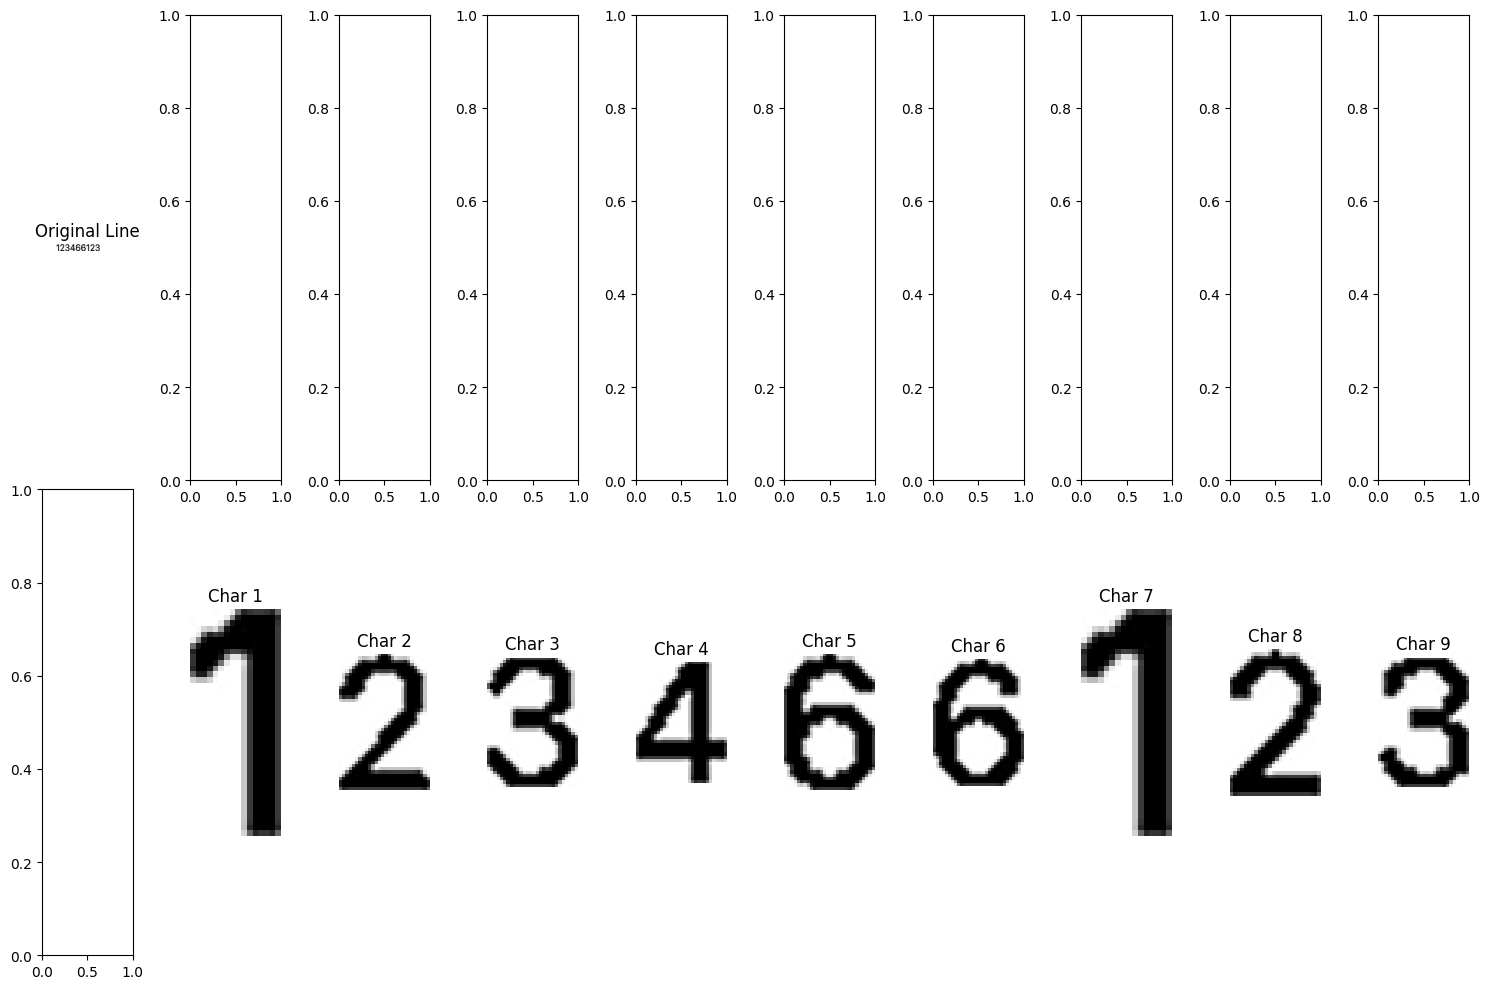

Processing line 2
  Detected 9 characters


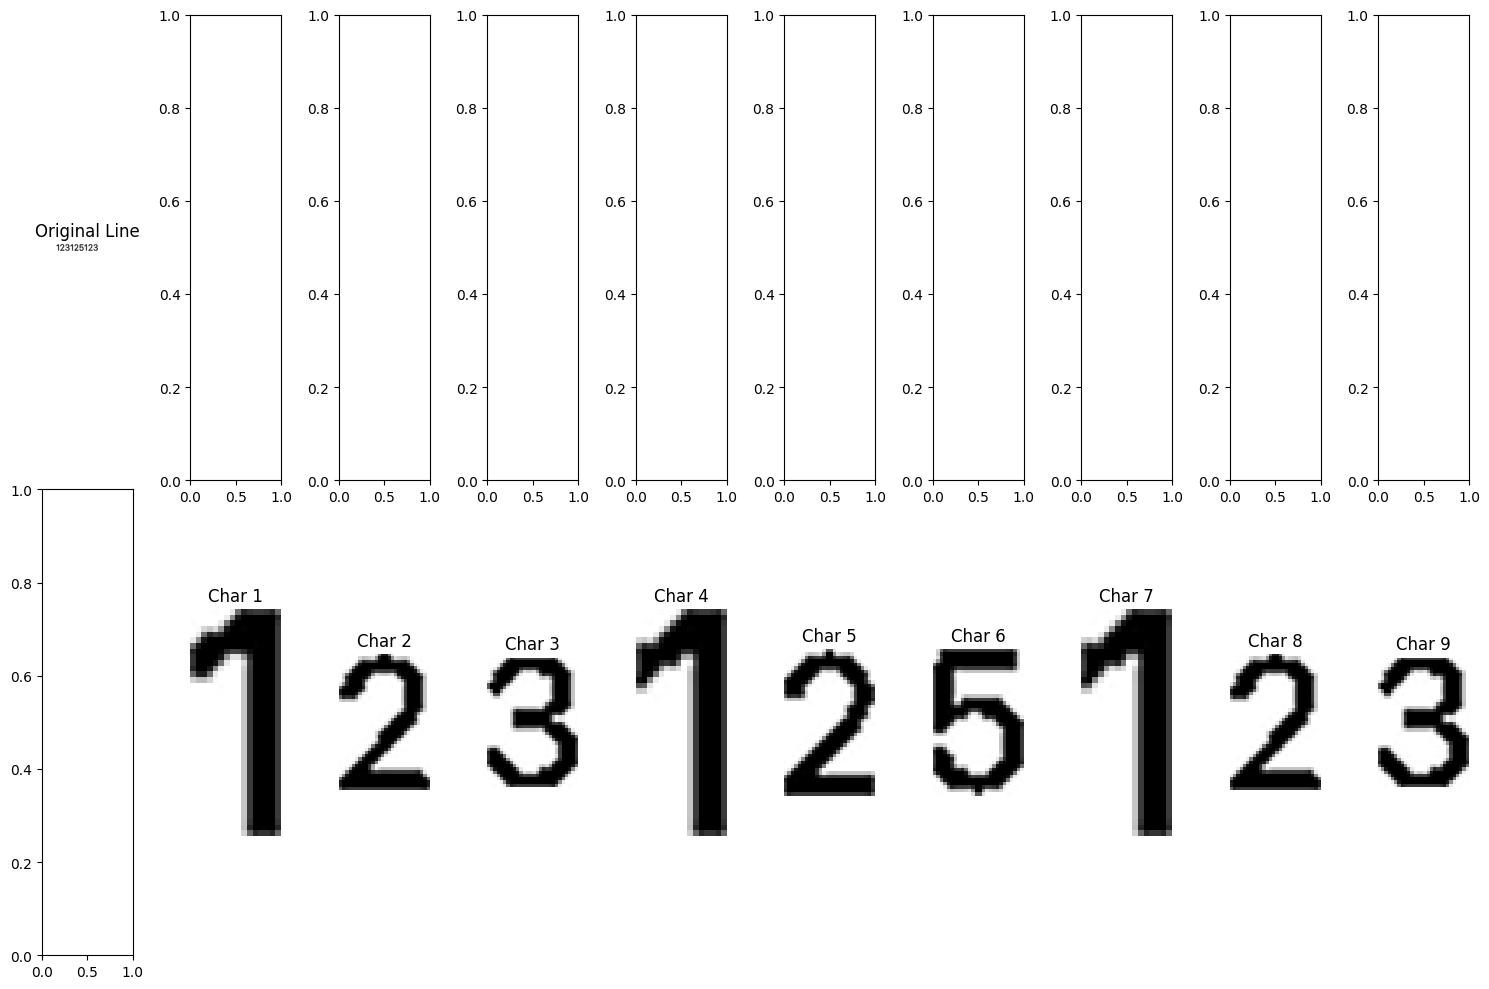

Processing line 3
  Detected 10 characters


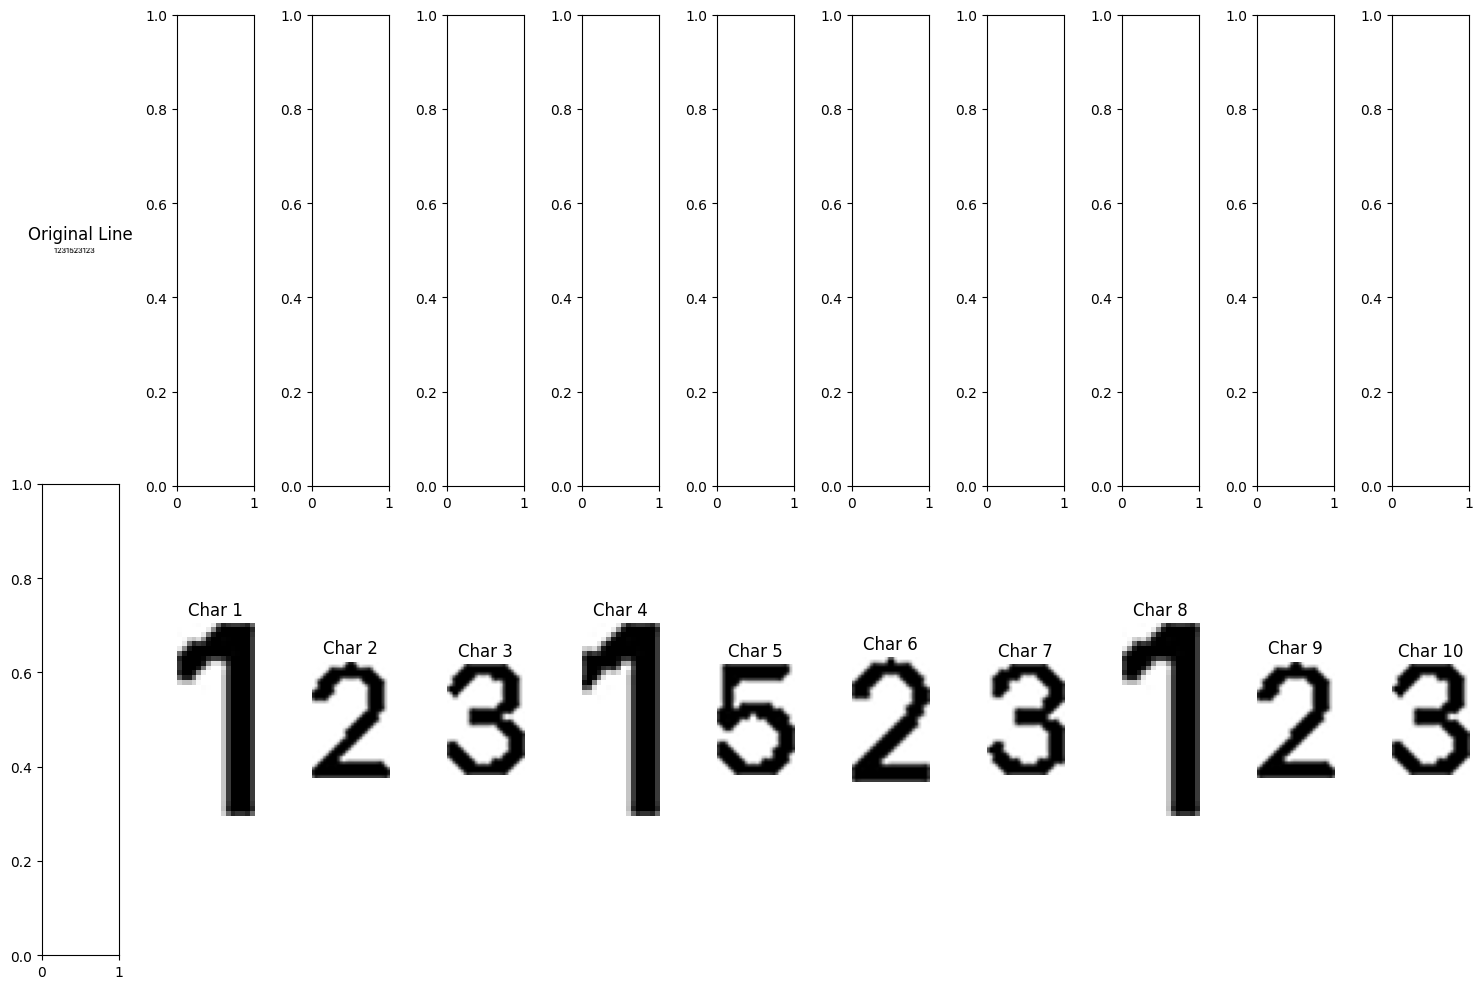

Processing line 4
  Detected 14 characters


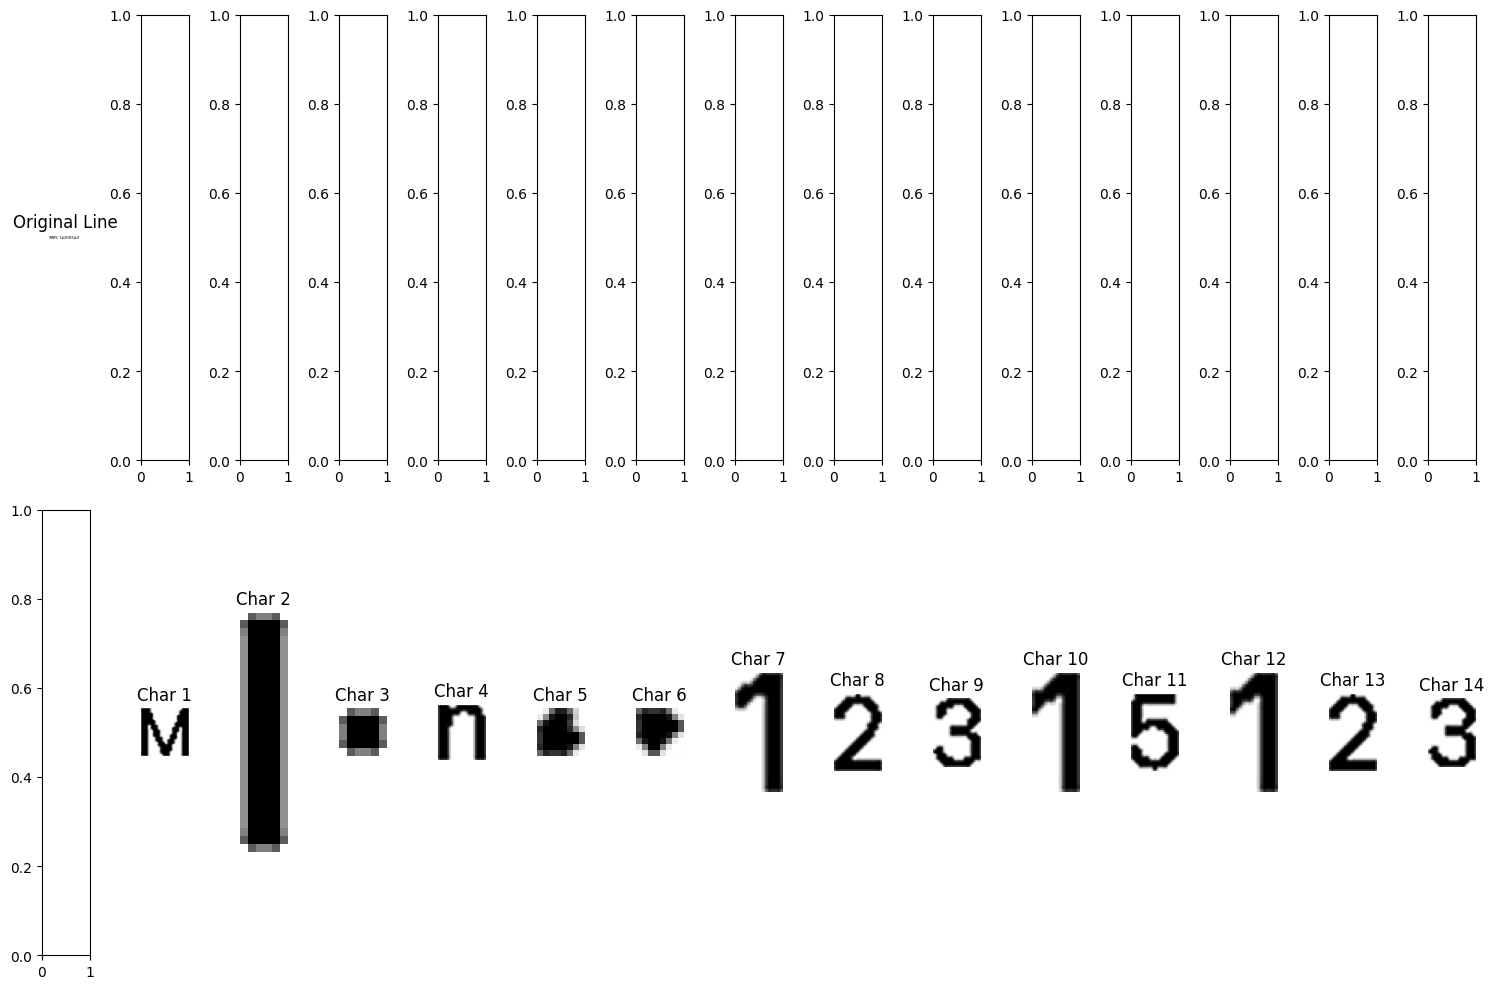

Processing line 5
  Detected 15 characters


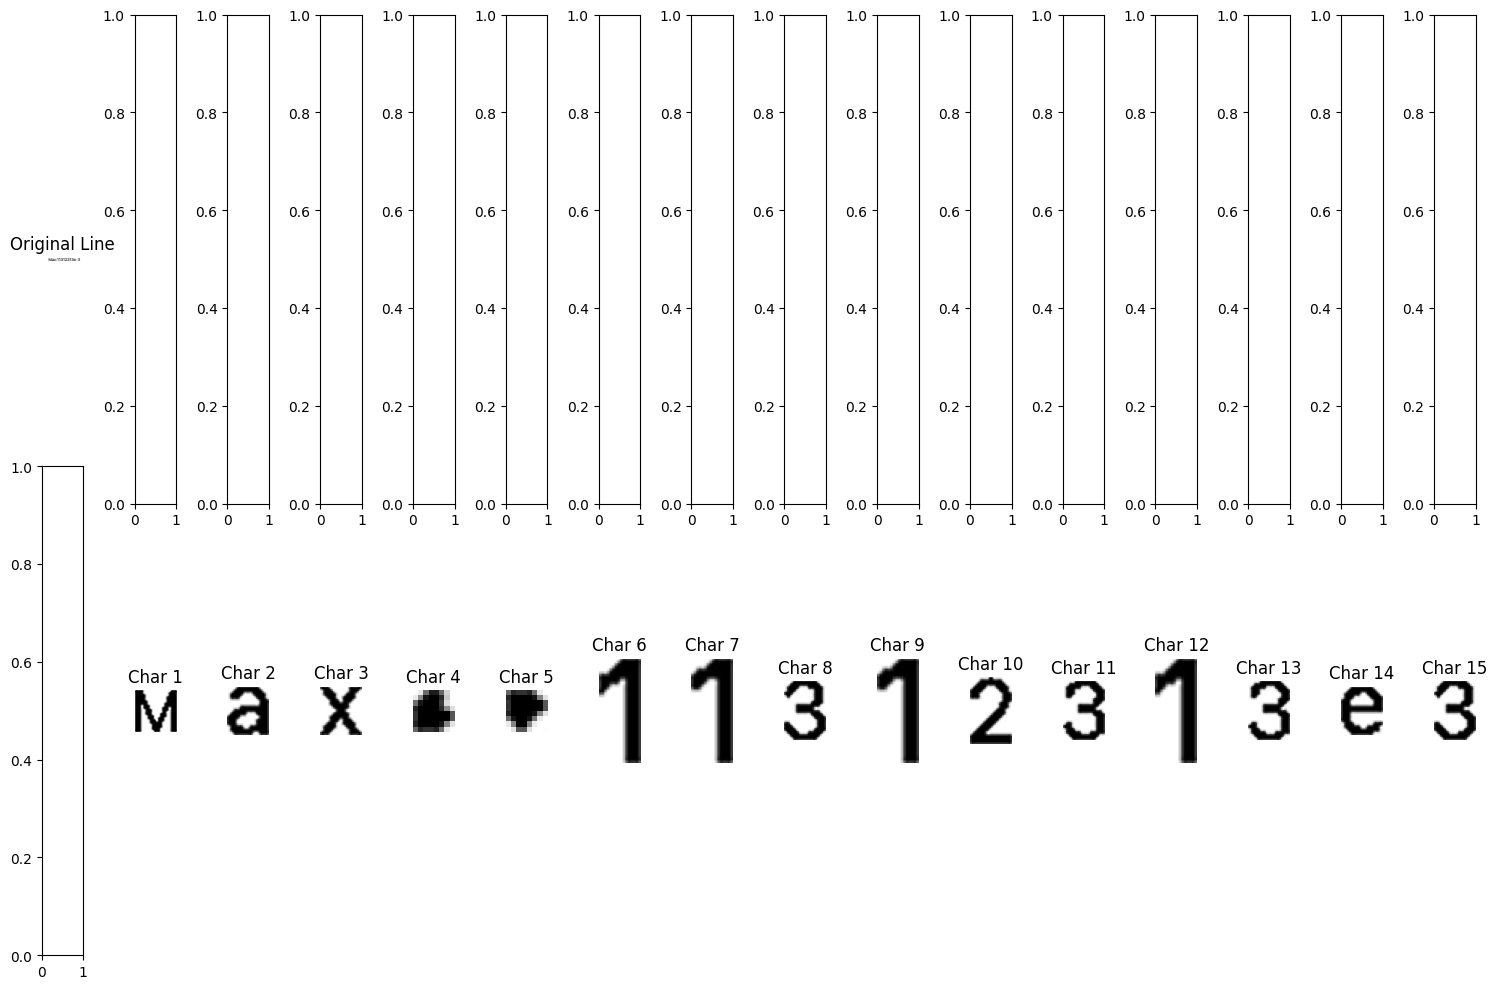

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_characters(line_image, min_char_width=5, min_char_height=5):
    # 确保图像是二值化的
    if len(line_image.shape) == 3:
        line_image = cv2.cvtColor(line_image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(line_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 寻找轮廓
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 根据轮廓分割字符
    char_images = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w >= min_char_width and h >= min_char_height:
            char_image = line_image[y:y+h, x:x+w]
            char_images.append((x, char_image))

    # 按 x 坐标排序，确保从左到右的顺序
    char_images.sort(key=lambda x: x[0])

    return [char[1] for char in char_images]


def visualize_char_segments(line_image, char_images):
    num_chars = len(char_images)
    fig, axs = plt.subplots(2, num_chars + 1, figsize=(15, 10))

    # Ensure axs is always a 2D array even when there's only one column
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    # Display the original line image
    axs[0, 0].imshow(line_image, cmap='gray')
    axs[0, 0].set_title("Original Line")
    axs[0, 0].axis('off')

    # Display each character image
    for i, char_image in enumerate(char_images):
        axs[1, i+1].imshow(char_image, cmap='gray')
        axs[1, i+1].set_title(f"Char {i+1}")
        axs[1, i+1].axis('off')

    plt.tight_layout()
    plt.show()

print(f"检测到 {len(line_images)} 行")

# 对每一行进行字符分割
for i, line_image in enumerate(line_images):
    print(f"Processing line {i+1}")
    char_images = segment_characters(line_image)
    print(f"  Detected {len(char_images)} characters")

    # 可视化字符分割结果
    visualize_char_segments(line_image, char_images)

    # 保存每个字符的图像
    # for j, char_image in enumerate(char_images):
    #     cv2.imwrite(f'line_{i+1}_char_{j+1}.jpg', char_image)


## 单个数字识别